## Load Data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
import glob
from scipy import interpolate
from collections import Counter

In [10]:
types_vocab = ["EXP", "HIB", "LP", "PIS", "TOR", "TR", "VT"]

In [11]:

table = pd.read_excel("data/association_table_corrected_index.xlsx")

In [12]:
table.head()

,Index,Event,Duration,Event start,Event stop,File name,File start,File end,Sampling rate,Overlap,Unnamed: 10,Unnamed: 11,Unnamed: 12,npts,energy,path
0,0,LP1,33,2006-05-23 20:39:27.060000+00:00,2006-05-23 20:40:00.060000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.24403,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
1,1,LP1,45,2006-05-23 20:39:59.960000+00:00,2006-05-23 20:40:44.960000+00:00,20060523_2033.UB1.SL.Z.sac,2006-05-23 20:33:05.895000+00:00,2006-05-23 20:43:05.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.11833,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
2,2,TR2,128,2006-05-23 22:37:52.910000+00:00,2006-05-23 22:40:00.910000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,0.79052,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
3,3,LP1,32,2006-05-23 22:44:09.410000+00:00,2006-05-23 22:44:41.410000+00:00,20060523_2235.UB1.SL.Z.sac,2006-05-23 22:35:19.895000+00:00,2006-05-23 23:05:19.875000+00:00,50.0,False,NaN,NaN,NaN,90000.0,1.15570,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...
4,4,TR2,78,2006-05-23 22:46:58.440000+00:00,2006-05-23 22:48:16.440000+00:00,20060523_2245.UB1.SL.Z.sac,2006-05-23 22:45:19.895000+00:00,2006-05-23 22:55:19.885000+00:00,100.0,False,NaN,NaN,NaN,60000.0,0.23330,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...


## Make list of spectrograms

In [13]:
t_itp = np.linspace(0, 120, 25)
f_itp = np.linspace(0, 10 ,25)

In [15]:
dict_interps = dict()
counter = Counter()
list_interps = []
list_types = []

In [16]:
# shuffle the dataframe
table = table.sample(frac=1)

In [17]:
for index, row in table.iterrows():
    event = row["Event"]
    event_type = event if event in types_vocab else event[:-1]
    if counter[event_type] >= 30:
        continue
    name = event_type + "_" + str(row["Index"])
    filename = name + ".npy"
    try:
        ts = np.load(f"data/Extracted/{event_type}/{filename}")
        f,t,S = signal.spectrogram(ts,row["Sampling rate"])
        func = interpolate.RectBivariateSpline(f,t,S)
    except:
        continue
    S_int = func(f_itp, t_itp)
    # dict_interps[name] = S_int
    list_interps.append(S_int)
    list_types.append(event_type)
    counter[event_type] += 1

In [20]:
len(list_interps)

210

In [21]:
Counter(list_types)

Counter({'TR': 30,
         'LP': 30,
         'PIS': 30,
         'EXP': 30,
         'VT': 30,
         'TOR': 30,
         'HIB': 30})

In [ ]:

# np.savez("./dataset_spectro", **dict_interps)

## Datasets

In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
list_types = le.fit_transform(list_types)

In [39]:
dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types))
dataset

<TensorSliceDataset shapes: ((25, 25), ()), types: (tf.float64, tf.int64)>

In [40]:
dataset = tf.data.Dataset.from_tensor_slices((list_interps, list_types))
dataset = dataset.shuffle(30)
test_dataset = dataset.take(10) 
train_dataset = dataset.skip(10)
test_dataset = test_dataset.batch(1)
train_dataset = train_dataset.batch(1)
# train_dataset = tf.data.Dataset.from_tensor_slices((list_interps[:20], list_types[:20]))
# test_dataset = tf.data.Dataset.from_tensor_slices((list_interps[20:], list_types[20:]))

In [41]:
test_dataset

<BatchDataset shapes: ((None, 25, 25), (None,)), types: (tf.float64, tf.int64)>

/tmp/ipykernel_39901/1221987843.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_itp,f_itp,list_interps[8])


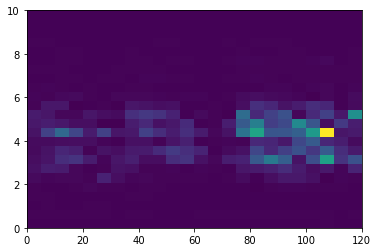

In [42]:
plt.pcolormesh(t_itp,f_itp,list_interps[8])

In [43]:
from tensorflow.keras import datasets, layers, models

In [44]:
model = models.Sequential()
model.add(layers.Reshape((25,25,1), input_shape=(25,25)))
model.add(layers.Conv2D(16, (3,3), activation = "relu", input_shape = (25,25,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation = "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3), activation = "relu"))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(7))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 25, 25, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 16)          4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [46]:
history = model.fit(train_dataset, epochs=10)

Epoch 1/10


2021-11-16 16:10:47.167533: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-11-16 16:10:48.085922: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-16 16:10:48.087912: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-16 16:10:48.087943: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2021-11-16 16:10:48.089927: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-16 16:10:48.089998: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


200/200 [==============================] - 4s 3ms/step - loss: 6505.1138 - accuracy: 0.2850
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 6894.7505 - accuracy: 0.2800
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 1570.8800 - accuracy: 0.2300
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 8678.6680 - accuracy: 0.2150
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 1420.7997 - accuracy: 0.2800
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 926.9604 - accuracy: 0.3400
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 461.6359 - accuracy: 0.3100
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 228.4127 - accuracy: 0.3400
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 119.8696 - accuracy: 0.3350
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 71.3802 - acc

In [47]:
model.evaluate(test_dataset)

10/10 [==============================] - 0s 3ms/step - loss: 220.4789 - accuracy: 0.4000


[220.47885131835938, 0.4000000059604645]